In [8]:
# https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/qip-randomized-benchmarking.ipynb
# https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/qip-customize-device.ipynb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import numpy as np
from qutip import sigmax, sigmay, sigmaz, basis, qeye, tensor, Qobj, fock_dm
from qutip_qip.circuit import QubitCircuit, Gate
from qutip_qip.device import ModelProcessor, Model, CavityQEDModel
from qutip_qip.compiler import GateCompiler, Instruction, CavityQEDCompiler
from qutip import Options
from qutip_qip.noise import Noise

In [30]:
num_qubits = 2
num_c_levels = 10
delta_init = 0 # coupling between qubit states
g1,g2 = 1.0, 1.0
wc = 0.01 # resonator frequency
g = [g1,g2] # coupling strength between qubit + resonator
epsmax = [1,0.02]
deltamax = [0, 2.852]
model = CavityQEDModel(2,10, delta = delta_init, g=g, w0=wc, deltamax = deltamax, epsmax = epsmax)


[{'sx0': '$\\sigma_x^0$', 'sx1': '$\\sigma_x^1$'},
 {'sz0': '$\\sigma_z^0$', 'sz1': '$\\sigma_z^1$'},
 {'g0': '$g^0$', 'g1': '$g^1$'}]

In [17]:
class MyCompiler(GateCompiler):
    """Custom compiler for generating pulses from gates using the base class 
    GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses such as
                       the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "ROT": self.rotation_with_phase_compiler,
            "RX": self.single_qubit_gate_compiler,
#             "RY": self.single_qubit_gate_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction): An instruction
            to implement a gate containing the control pulses.                                               
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
#             ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.
        
        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
        
        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction): An instruction
            to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        tlist = np.abs(gate.arg_value) / self.params["pulse_amplitude"]
        coeff = self.params["pulse_amplitude"] * np.sign(gate.arg_value)
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist, coeff, phase=0.0)
#         elif gate.name == "RY":
#             return self.generate_pulse(gate, tlist, coeff, phase=np.pi / 2)

    def rotation_with_phase_compiler(self, gate, args):
        """Compiles gates with a phase term.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
        
        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction): An instruction
            to implement a gate containing the control pulses.
        """
        # gate.arg_value is the pulse phase
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff, phase=gate.arg_value)

In [67]:
class ClassicalCrossTalk(Noise):
    def __init__(self, ratio):
        self.ratio = ratio

    def get_noisy_dynamics(self, dims=[10,2,2], pulses=None, systematic_noise=None):
        """Adds noise to the control pulses.
        
        Args:
            dims: Dimension of the system, e.g., [2,2,2,...] for qubits.
            pulses: A list of Pulse objects, representing the compiled pulses.
            systematic_noise: A Pulse object with no ideal control, used to represent
            pulse-independent noise such as decoherence (not used in this example).
        Returns:
            pulses: The list of modified pulses according to the noise model.
            systematic_noise: A Pulse object (not used in this example). 
        """
        for i, pulse in enumerate(pulses):
            if "sx" not in pulse.label and "sy" not in pulse.label:
                continue  # filter out other pulses, e.g. drift
            target = pulse.targets[0]
            if target != 0:  # add pulse to the left neighbour
                pulses[i].add_control_noise(
                    self.ratio * pulse.qobj,
                    targets=[target - 1],
                    coeff=pulse.coeff,
                    tlist=pulse.tlist,
                )
            if target != len(dims) - 1:  # add pulse to the right neighbour
                pulses[i].add_control_noise(
                    self.ratio * pulse.qobj,
                    targets=[target + 1],
                    coeff=pulse.coeff,
                    tlist=pulse.tlist,
                )
        return pulses, systematic_noise

In [71]:
num_gates = 250 # Qubit-0 is the target qubit. Qubit-1 suffers from crosstalk.
num_sample = 2
fidelity = []
fidelity_error = []
init_fid = 0.975
num_gates_list = [250]

def crosstalk_sim(num_gates):
    num_qubits = 2
    # Add qubit frequency detuning 1.852MHz for the second qubit.
    qc = QubitCircuit(num_qubits)
    processor = ModelProcessor(model=model)
    processor.add_drift(2 * np.pi * (sigmaz() + 1) / 2 * 1.852, targets=1)
    # Define a random circuit.
    gates_set = [
        Gate("ROT", 0, arg_value=0),
        Gate("ROT", 0, arg_value=np.pi / 2),
        Gate("ROT", 0, arg_value=np.pi),
        Gate("ROT", 0, arg_value=np.pi / 2 * 3),
    ]

    for ind in np.random.randint(0, 4, num_gates):
        qc.add_gate(gates_set[ind])

    mycompiler = MyCompiler(num_qubits, {"pulse_amplitude": 0.02, "duration": 25})
    processor.load_circuit(qc, compiler=mycompiler)
    noise = ClassicalCrossTalk(1.0).get_noisy_dynamics(dims=[10,2,2])
    processor.add_noise(noise)

    init_state = tensor([qeye(10),Qobj([[init_fid, 0], [0, 0.025]]), Qobj([[init_fid, 0], [0, 0.025]])])
    options = Options(nsteps=10000)  # increase the maximal allowed steps
    e_ops = [tensor(qeye(num_c_levels), fock_dm(2), qeye(num_qubits))]  # observable, changed dims 
    result = processor.run_state(init_state, solver="mesolve", options=options, e_ops=e_ops)
    result = result.expect[0][-1]  # measured expectation value at the end
    return result             

In [72]:
for num_gates in num_gates_list:
    # expect = Parallel(n_jobs=8)(delayed(single_crosstalk_simulation)(num_gates) for i in range(num_sample))
    expect = [crosstalk_sim(num_gates) for i in range(num_sample)]
    fidelity.append(np.mean(expect))
    fidelity_error.append(np.std(expect)/np.sqrt(num_sample))

TypeError: 'NoneType' object is not iterable

/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


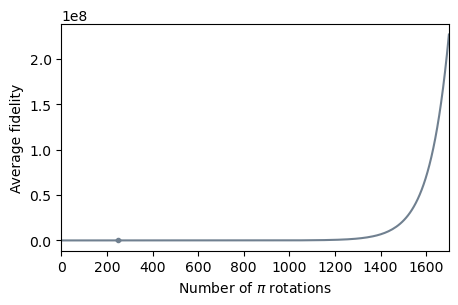

In [38]:
def rb_curve(x, a):
    return (1 / 2 + np.exp(-2 * a * x) / 2) * 0.975


pos, cov = curve_fit(rb_curve, num_gates_list, fidelity, p0=[0.001])

xline = np.linspace(0, 1700, 200)
yline = rb_curve(xline, *pos)

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
ax.errorbar(
    num_gates_list, fidelity, yerr=fidelity_error, fmt=".", capsize=2, color="slategrey"
)
ax.plot(xline, yline, color="slategrey")
ax.set_ylabel("Average fidelity")
ax.set_xlabel(r"Number of $\pi$ rotations")
ax.set_xlim((0, 1700));